<a href="https://colab.research.google.com/github/kevingray92/597_Project4_GroupB/blob/develop-linear-model/Project4_LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
#gfs = pd.read_csv('./raw_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
gfs = pd.read_csv('drive/My Drive/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
# gfsfs = pd.read_csv('./raw_data/GFS_Sfc_42hrFcst_2010thru2019.csv', skiprows=1, index_col = 'Date', parse_dates = True)

#oldobs = pd.read_csv('./raw_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
oldobs = pd.read_csv('drive/My Drive/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
oldobs.index = oldobs.index + pd.DateOffset(hours=12)  # Align times

#obs = pd.read_csv('./raw_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs = pd.read_csv('drive/My Drive/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs.index = obs.index + pd.DateOffset(hours=12)  # Align times

In [0]:
# Merge and drop all days with missing values 
features = pd.merge(obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, oldobs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features.dropna(inplace = True)  # There are some NaNs in the observations

In [4]:
features

,Date,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h
0,2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0,-11.26,-16.46,7.323933,0.05,-7.590909,-11.154545,1022.190909,288.181818,7.036364,2.090909,0.000
1,2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0,-10.16,-15.96,4.687217,0.00,-13.008333,-16.616667,1029.875000,290.833333,6.066667,3.583333,0.000
2,2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0,-9.96,-14.36,5.941380,0.06,-17.091667,-20.558333,1032.716667,306.666667,4.108333,0.000000,0.000
3,2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0,-8.46,-12.86,5.685068,0.17,-14.550000,-18.458333,1031.466667,304.166667,3.933333,0.166667,0.000
4,2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0,-7.16,-11.06,3.794733,0.77,-12.908333,-16.408333,1027.250000,288.333333,7.341667,3.916667,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,2019-12-26 12:00:00,16.666667,7.777778,8.04672,0.0,11.84,3.84,4.301163,0.00,12.233333,8.241667,1013.433333,173.333333,5.741667,0.000000,0.000
3609,2019-12-27 12:00:00,6.111111,0.000000,6.70560,0.0,13.94,3.54,8.819297,2.73,12.225000,10.358333,1017.009091,224.166667,4.366667,1.750000,0.000
3610,2019-12-28 12:00:00,13.333333,0.000000,10.28192,2.7,15.94,9.34,9.701546,11.58,2.166667,0.383333,1025.200000,127.500000,2.066667,0.750000,0.000
3611,2019-12-29 12:00:00,15.000000,5.000000,10.28192,4.0,7.24,-1.66,11.111256,2.57,11.258333,10.658333,1013.350000,119.166667,7.016667,9.000000,0.225


In [5]:
features.describe()

,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h
count,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000
mean,17.537698,6.489445,7.598453,2.078561,16.103403,7.178365,5.768162,3.347643,13.784983,6.969115,1016.964704,183.175597,4.658326,1.856453,0.075684
std,11.936209,10.837186,2.923450,6.274578,11.222346,10.004560,2.338025,7.179312,11.618374,10.832349,6.915968,75.123158,2.175907,2.405758,0.330217
min,-21.111111,-26.666667,2.235200,0.000000,-18.760000,-25.060000,1.431782,0.000000,-22.766667,-26.991667,992.290909,7.272727,0.250000,0.000000,-0.100000
25%,8.333333,-1.666667,5.811520,0.000000,7.140000,-0.660000,3.984972,0.000000,4.450000,-1.262500,1012.704167,130.833333,3.043561,0.000000,0.000000
50%,20.000000,7.777778,7.152640,0.000000,18.140000,8.440000,5.393515,0.310000,15.875000,7.541667,1016.516667,185.833333,4.333333,0.909091,0.000000
75%,27.777778,16.111111,9.387840,0.500000,25.940000,15.540000,7.185750,3.345000,24.025000,16.570833,1020.937500,239.166667,5.925000,2.366667,0.000000
max,37.777778,25.555556,23.246080,89.000000,37.140000,25.040000,16.413714,94.690000,33.941667,26.433333,1044.875000,352.500000,15.775000,9.000000,7.416667


In [0]:
# Add year, month, day as integers 
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

In [0]:

# The data we will be using to predict the labels
new_features = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)
new_features_date = features.drop(columns = ['Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# Save feature list for later
feature_list = list(new_features.columns)

In [14]:
new_features

,TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,year,month,day
0,-11.26,-16.46,7.323933,0.05,-7.590909,-11.154545,1022.190909,288.181818,7.036364,2.090909,0.000,2010,1,1
1,-10.16,-15.96,4.687217,0.00,-13.008333,-16.616667,1029.875000,290.833333,6.066667,3.583333,0.000,2010,1,2
2,-9.96,-14.36,5.941380,0.06,-17.091667,-20.558333,1032.716667,306.666667,4.108333,0.000000,0.000,2010,1,3
3,-8.46,-12.86,5.685068,0.17,-14.550000,-18.458333,1031.466667,304.166667,3.933333,0.166667,0.000,2010,1,4
4,-7.16,-11.06,3.794733,0.77,-12.908333,-16.408333,1027.250000,288.333333,7.341667,3.916667,0.000,2010,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,11.84,3.84,4.301163,0.00,12.233333,8.241667,1013.433333,173.333333,5.741667,0.000000,0.000,2019,12,26
3609,13.94,3.54,8.819297,2.73,12.225000,10.358333,1017.009091,224.166667,4.366667,1.750000,0.000,2019,12,27
3610,15.94,9.34,9.701546,11.58,2.166667,0.383333,1025.200000,127.500000,2.066667,0.750000,0.000,2019,12,28
3611,7.24,-1.66,11.111256,2.57,11.258333,10.658333,1013.350000,119.166667,7.016667,9.000000,0.225,2019,12,29


### Run the Linear Regression Model for TMAX

In [0]:
# Split the data into training and testing sets
#train_features = np.array(new_features.query('year < 2019'))
#test_features = np.array(new_features.query('year == 2019'))
train_features = np.array(new_features.query('year < 2019')['TMAX'])
test_features = np.array(new_features.query('year == 2019')['TMAX'])
train_labels = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_labels = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

In [67]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['TMAX'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.42 degrees C.


In [68]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2965,)
Training Labels Shape: (2965,)
Testing Features Shape: (314,)
Testing Labels Shape: (314,)


In [70]:
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

lrmax.fit(train_features[:, np.newaxis], train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
predictions = lrmax.predict(test_features[:, np.newaxis])
# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'degrees C.')

Root Mean Square Error: 4.36 degrees C.


In [73]:
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Model slope:     0.9904579777155287
Model intercept: 1.6400241657102477


In [0]:
#new_features_date['Date'].shape
#test_labels.shape
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
#test_dates

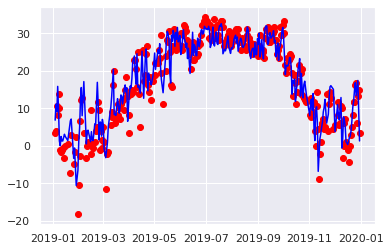

In [75]:
plt.scatter(test_dates, test_labels, c='red')
plt.plot(test_dates, predictions, c='blue')

### Run the Linear Regression Model for TMIN

In [0]:
# Split the data into training and testing sets
#train_features = np.array(new_features.query('year < 2019'))
#test_features = np.array(new_features.query('year == 2019'))
train_features = np.array(new_features.query('year < 2019')['TMIN'])
test_features = np.array(new_features.query('year == 2019')['TMIN'])
train_labels = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_labels = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

In [77]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['TMIN'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.3 degrees C.


In [78]:
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

lrmax.fit(train_features[:, np.newaxis], train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
predictions = lrmax.predict(test_features[:, np.newaxis])
# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'degrees C.')

Root Mean Square Error: 4.22 degrees C.


In [80]:
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Model slope:     1.003285425685588
Model intercept: -0.6984030017556284


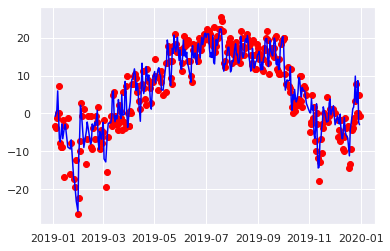

In [81]:
plt.scatter(test_dates, test_labels, c='red')
plt.plot(test_dates, predictions, c='blue')

### Run the Linear Regression Model for Max Wind Speed

In [0]:
# Split the data into training and testing sets
#train_features = np.array(new_features.query('year < 2019'))
#test_features = np.array(new_features.query('year == 2019'))
train_features = np.array(new_features.query('year < 2019')['WMAX'])
test_features = np.array(new_features.query('year == 2019')['WMAX'])
train_labels = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_labels = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

In [83]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['WMAX'].values)), 2), 'm/s.')

Root Mean Square Error: 3.28 m/s.


In [84]:
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

lrmax.fit(train_features[:, np.newaxis], train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
predictions = lrmax.predict(test_features[:, np.newaxis])
# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'm/s.')

Root Mean Square Error: 2.74 m/s.


In [87]:
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Model slope:     0.5473614844589794
Model intercept: 4.470488864944006


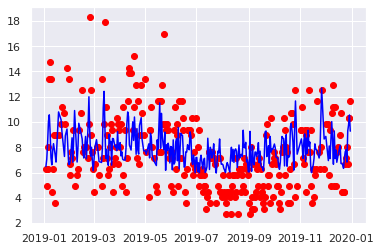

In [88]:
plt.scatter(test_dates, test_labels, c='red')
plt.plot(test_dates, predictions, c='blue')

### Run the Linear Regression Model for Total Precipitation

In [0]:
# Split the data into training and testing sets
#train_features = np.array(new_features.query('year < 2019'))
#test_features = np.array(new_features.query('year == 2019'))
train_features = np.array(new_features.query('year < 2019')['RTOT'])
test_features = np.array(new_features.query('year == 2019')['RTOT'])
train_labels = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_labels = np.array(features.query('year == 2019')['Daily Precip (mm)'])

In [90]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['RTOT'].values)), 2), 'mm.')

Root Mean Square Error: 7.9 mm.


In [91]:
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

lrmax.fit(train_features[:, np.newaxis], train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
predictions = lrmax.predict(test_features[:, np.newaxis])
# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'mm.')

Root Mean Square Error: 4.93 mm.


In [93]:
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Model slope:     0.10191262925131268
Model intercept: 1.7487485544605212


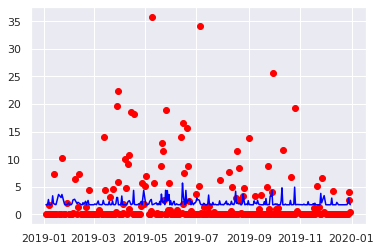

In [94]:
plt.scatter(test_dates, test_labels, c='red')
plt.plot(test_dates, predictions, c='blue')